# Project 1: Bay Area Bikeshare
Jennifer Philippou

6/4/2018

Objective:
    You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.
    
Through this project, you will answer these questions:

    1. What are the 5 most popular trips that you would call "commuter trips"?
    2. What are your recommendations for offers (justify based on your findings)?

In [13]:
#enviornment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Part 1: Defining a Commuter

In order to answer the leader's questions, we must first confirm the days and times with high traffic. Large volumes of traffic are the telltale sign of prime commuting hours. We tried to keep this production oriented so there is a single clean script that generates all queries and the corresponding data and this script loads and analyzes the output from the data pipeline. 

In [61]:
df_c_day = pd.read_csv("~/data/day_of_week.csv")

The data confirms that day 1 is Sunday and day 7 is Saturday so the data from those two days will be excluded because its not part of the traditional commute. We can deduce this from the lower ridership levels on those days and the definition of the DAYOFWEEK function in STD SQL's extract command (https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators). See table below.

In [66]:
#ridership count by day of week
df_c_day

,count,c_day
0,159977,6
1,60279,7
2,180767,4
3,184405,3
4,176908,5
5,169937,2
6,51375,1


Now that we have identified the typical communting days, let's look at what times are popular for commuting. As the data below shows, we have grouped the trip_counts by hour (excluding Saturday and Sunday's data) and can see a clear bimodal distribution in the data. These peaks occur at 8 and 17, which tells us that while the data is labeld as UTC, it is in fact more likely to be Pacific Standard time. In order to capture the complete window of commuting the hour before and after the peak will be considered prime communting time too; making the final commute window 7-9 am and 16-18 (4-6pm). 

In [57]:
df_c_time = pd.read_csv("~/data/commuter_time_eda.csv")

In [58]:
df_c_time.head()

,trip_count,c_hour,c_day
0,427,0,6
1,228,0,2
2,302,0,3
3,359,0,4
4,380,0,5


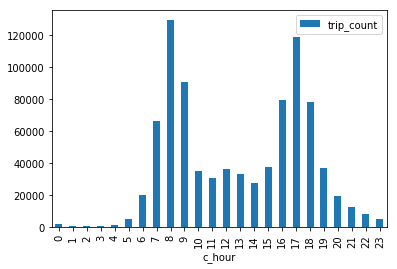

In [59]:
pd.pivot_table(df_c_time,index=["c_hour"],values=["trip_count"],aggfunc=np.sum).plot.bar()

Next we want to idenify the top trips during commute time. We will take the aforementioned parameters and apply them as filters to refine the count of trips and adding some new variables (the starting and ending stations) to find the most popular paths.

In [71]:
df_top_trips = pd.read_csv('~/data/top_commute_trips.csv')

The top five trips (not factoring the time of day) is shown below:

In [83]:
df_top_trips.loc[(df_top_trips['c_trip'] == True)].head()

,start_station_name,end_station_name,PM_trip,AM_trip,c_trip,trip_count
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,False,True,True,4509
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),True,False,True,4191
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),True,False,True,4022
3,Embarcadero at Sansome,Steuart at Market,True,False,True,3863
4,Steuart at Market,2nd at Townsend,False,True,True,3759


The top five trips in the AM is shown below:

In [82]:
df_top_trips.loc[(df_top_trips['AM_trip'] == True)].head()

,start_station_name,end_station_name,PM_trip,AM_trip,c_trip,trip_count
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,False,True,True,4509
4,Steuart at Market,2nd at Townsend,False,True,True,3759
5,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,False,True,True,3512
7,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,False,True,True,3364
11,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),False,True,True,3126


The top five trips in the PM is shown below:

In [81]:
df_top_trips.loc[(df_top_trips['PM_trip'] == True)].head()

,start_station_name,end_station_name,PM_trip,AM_trip,c_trip,trip_count
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),True,False,True,4191
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),True,False,True,4022
3,Embarcadero at Sansome,Steuart at Market,True,False,True,3863
6,Steuart at Market,San Francisco Caltrain (Townsend at 4th),True,False,True,3393
8,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),True,False,True,3326


As you can see from above, there is a fair amount of overlap between the time of day, but people make stops at the market in the evening commute.

## Part II: Evaulating Current Offerings

What type of membership is currently associated with commute times? Note there is some divergence from the table schema description of memembership and that of the original goal described in the project charter. Based on the data that is coming back, we will be relying on the schema and its definition of membership:

        Definitions: "Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member" from 
        https://bigquery.cloud.google.com/table/bigquery-public-data:san_francisco.bikeshare_trips?pli=1

In [90]:
df_s_type = pd.read_csv("~/data/subscriber_type.csv")

In [91]:
df_s_type

,subscriber_type,PM_trip,AM_trip,c_trip,trip_count
0,Subscriber,False,True,True,274885
1,Subscriber,False,False,False,260466
2,Subscriber,True,False,True,254986
3,Customer,False,False,False,50845
4,Customer,True,False,True,20534
5,Customer,False,True,True,10278


As the table above shows, there is an almost even balance between AM and PM commuter trips with a longer term membership. Additionally about 66% of long term membership aligns to commuters. The customer segment on the other hand, is much more skewed towards PM commutes with an trip count double that of the AM commute. Also of interest, the shorter term customer segment is more than 50% made up of non-commuters and this suggests the product offering is less appealing to the occasional commuter.

Maybe a half off offering in the AM customer segment would help to entice the evening commuters?

I was curious to see if there was a longer trip duration based on AM or PM commute by subscription type, but the next few tables show that is not particularly compelling.

In [96]:
df_duration_subscriber = pd.read_csv("~/data/trip_duration_by_subscriber.csv")

In [98]:
df_duration_subscriber.loc[0:10]

,trip_duration,subscriber_type,PM_trip,AM_trip,c_trip,trip_count
0,0,Subscriber,False,True,True,274327
1,0,Subscriber,False,False,False,259568
2,0,Subscriber,True,False,True,254393
3,0,Customer,False,False,False,41133
4,0,Customer,True,False,True,17970
5,0,Customer,False,True,True,8963
6,1,Customer,False,False,False,3834
7,2,Customer,False,False,False,1933
8,1,Customer,True,False,True,1418
9,3,Customer,False,False,False,1260


In [99]:
#customers hourly data
df_cust_dur = df_duration_subscriber[df_duration_subscriber['subscriber_type']=="Customer"]

In [101]:
df_cust_dur.head()

,trip_duration,subscriber_type,PM_trip,AM_trip,c_trip,trip_count
3,0,Customer,False,False,False,41133
4,0,Customer,True,False,True,17970
5,0,Customer,False,True,True,8963
6,1,Customer,False,False,False,3834
7,2,Customer,False,False,False,1933


As the next 2 visuals show, the majority of customer trips are less than 1 hr 

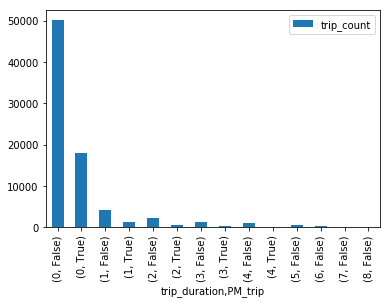

In [112]:
#customers hourly data by PM status
pd.pivot_table(df_cust_dur,index=["trip_duration","PM_trip"],values=["trip_count"],aggfunc=np.sum).plot.bar()

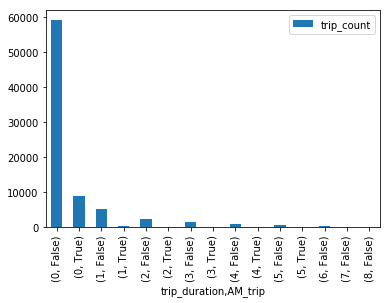

In [113]:
#customers hourly data by AM status
pd.pivot_table(df_cust_dur,index=["trip_duration","AM_trip"],values=["trip_count"],aggfunc=np.sum).plot.bar()

Now lets look at the 30 min cuttoff and see if it makes the most sense as a product offering.

In [7]:
df_trip_min = pd.read_csv('~/data/trip_min_subscriber.csv')

In [8]:
df_trip_min.head()

,trip_duration,subscriber_type,PM_trip,AM_trip,c_trip,trip_count
0,7,Subscriber,False,True,True,27871
1,8,Subscriber,False,True,True,27731
2,5,Subscriber,False,False,False,27404
3,6,Subscriber,False,True,True,26942
4,4,Subscriber,False,False,False,26618


It seems like the people not participating in the AM customer segment may be the ones that take 10-30 minutes for their PM travels(graph below shows a stronger left skew in the data). Interestingly, the trips are still mostly under 30 min so it is not the time cutoff that is reducing AM customer ridership. Perhaps there aren't enough bikes in the AM? or maybe people are just lazy. The company could create an offering for one way commuters, but I would imagine this might create logicistical challenges with bike supply and demand by location.

In [15]:
#filtering to customers that commute with bikes
df_trip_min2 = df_trip_min.loc[(df_trip_min['subscriber_type'] == "Customer")&(df_trip_min['c_trip'] == True)]

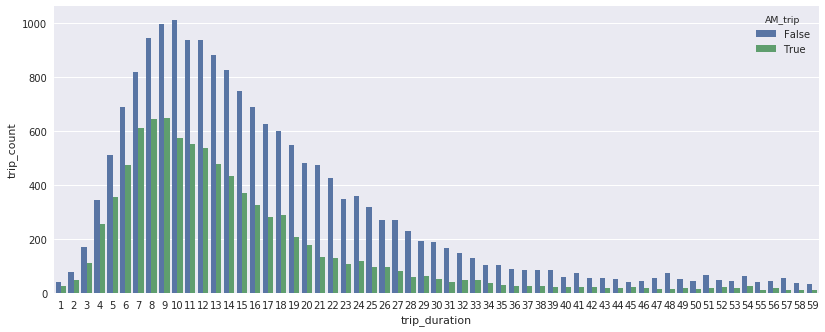

In [18]:
#Trips duration for customers that commute
sns.set(rc={'figure.figsize':(13.7,5.27)})
sns.barplot(x="trip_duration", y="trip_count", hue ="AM_trip", data = df_trip_min2)

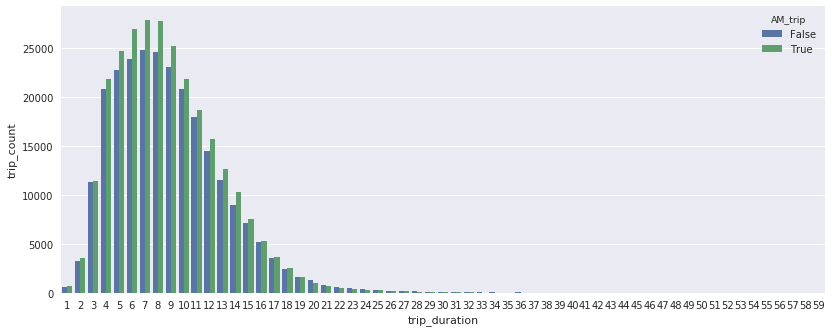

In [20]:
#trip duration for subscribers that commute = very balanced between AM and PM
df_trip_min3 = df_trip_min.loc[(df_trip_min['subscriber_type'] == "Subscriber")&(df_trip_min['c_trip'] == True)]
sns.barplot(x="trip_duration", y="trip_count", hue ="AM_trip", data = df_trip_min3)

We can see from the graph below that even the dedicated commuters take Fridays off (day 6). Perhaps offering an extened timeframe on Fridays for subscription commuters will boost ridership? 

In [120]:
df_subscr_day = pd.read_csv('~/data/subscriber_day.csv')

In [121]:
df_subscr_day.head()

,subscriber_type,c_day,PM_trip,AM_trip,c_trip,trip_count
0,Subscriber,3,False,True,True,59435
1,Subscriber,4,False,True,True,57680
2,Subscriber,3,True,False,True,55491
3,Subscriber,5,False,True,True,55458
4,Subscriber,3,False,False,False,54742


- Day 2 - Monday
- Day 3 - Tues
- Day 4 - Wed etc..

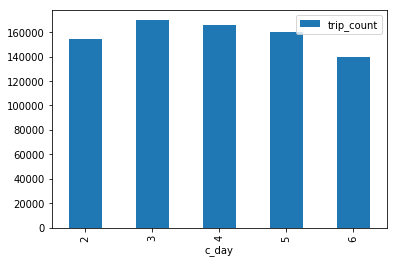

In [125]:
df_subsr_day_reg = df_subscr_day.loc[(df_subscr_day['subscriber_type'] == "Subscriber")]
pd.pivot_table(df_subsr_day_reg,index=["c_day"],values=["trip_count"],aggfunc=np.sum).plot.bar()

While we are looking across time, let's also look at seasonality. A discount in November and December and a premium in June-Aug could help to maximize revenue --esp if the schema is correct and there is already a 30 day membership.

In [24]:
df_month = pd.read_csv("~/data/subscriber_month.csv")

In [25]:
df_month.head()

,subscriber_type,month_trip,PM_trip,AM_trip,c_trip,trip_count
0,Subscriber,8,False,True,True,27033
1,Subscriber,6,False,True,True,26547
2,Subscriber,10,False,False,False,25949
3,Subscriber,7,False,True,True,25500
4,Subscriber,10,False,True,True,25079


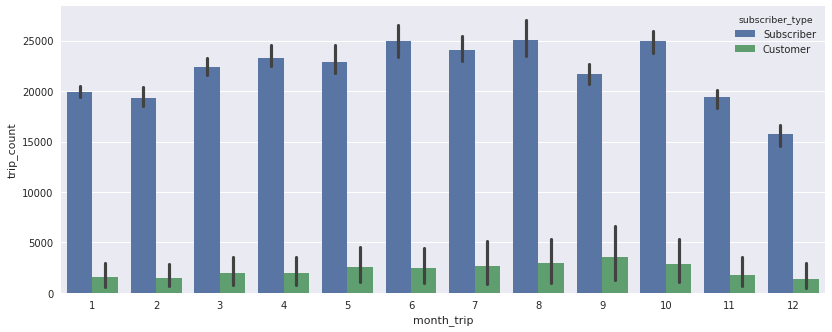

In [29]:
#seasonality by customer segment
sns.barplot(x="month_trip", y="trip_count", hue ="subscriber_type", data = df_month)

What areas are commonly using the bike share? Looking at the Zip Code data shows a large discrepancy between subscribers and customers. Most customers don't disclose their zip code (see top customer zip codes in the table below), but an offer that entices them to depart with this helpful information could provide dividends.

In [128]:
df_zip = pd.read_csv("~/data/zip_codes.csv")

In [129]:
df_zip.head()

,subscriber_type,zip_code,PM_trip,AM_trip,c_trip,trip_count
0,Subscriber,94107,False,False,False,39490
1,Subscriber,94107,False,True,True,27950
2,Subscriber,94107,True,False,True,24184
3,Subscriber,94105,False,False,False,21524
4,Subscriber,94105,False,True,True,15805


In [131]:
df_zip.loc[(df_zip['subscriber_type'] == "Customer")].head()

,subscriber_type,zip_code,PM_trip,AM_trip,c_trip,trip_count
19,Customer,nil,False,False,False,5804
57,Customer,NaN,False,False,False,2828
75,Customer,nil,True,False,True,2404
157,Customer,nil,False,True,True,1184
198,Customer,NaN,True,False,True,919


## Recommendation Summary:
    1. Offer a deal to get evening customers biking in the morning --> 2-10k more rides
    2. Offer a Friday Funday special that allows for longer evening trips to entice the community which drops off -->5-20k more rides
    3. Offer a discount in colder months and jack up prices in summer months --> 5-30k more rides
    4. Offer a deal to customers that are willing to provide a valid zip code to support future marketing efforts

# Please be sure to checkout the accompanying SQL script in the assignment 4 folder!